# Classifying Music Using Machine Learning

In this project I will use machine learning to classify music into genres. The data that I will use is "Predicting the Geographical Origin of Music" [1].

The file provides data on musical features for 1059 pieces of music, as well as geographical origin. There are two data files in this set, with the second containing chromatic features of the music in addition to the features provided in the first file. For this project, I am only considering the first file, which contains data on 68 musical features, as well as two columns on geographical origin (latitude and longitude).

The geographical origin is determined by the latitude and longitude of the capital city of the country or province where the data originated. Therefore, when plotting y, many data points will be on top of each other. Since this method of determining origin is not precise anyways, a small random offset is added to each point in y when it is plotted. Then, when plotting the positions, all points will be visible.


[1] Fang Zhou, Claire Q and Ross D. King. Predicting the Geographical Origin of Music, ICDM, 2014.
Available at: https://archive.ics.uci.edu/ml/datasets/Geographical+Original+of+Music 

In [1]:
from autograd import numpy as np
from matplotlib import pyplot as plt
rng = np.random.default_rng()

In [2]:
# load the music data
datapath = "GeographicalOriginOfMusic/"
data = np.loadtxt(datapath + 'default_features_1059_tracks.txt',delimiter=',')

# shuffle the data
rng.shuffle(data, axis=0)

# split the data into musical features (x) and geographical origin (y)
x = data[:, :68]
y = data[:, 68:]

# random offset so points in y aren't on top of each other (for plotting only)
y_offset = y + rng.standard_normal(y.shape) * 2

# reshape x for easier numpy operations during K-clustering
x.shape = (x.shape[0], 1, x.shape[1])

To begin, we apply K-means clustering to the musical features data, with several values of K. K-means clustering is a method which groups the data into K groups. Initially, it chooses K points at random, called centroids. The data points are clustered with the nearest centroid, then the centroid is moved to the mean position of the data points clustered with it. This is repeated until a good clustering is found.

A cost for the classification is determined by the average over the distance squared from each point to the nearest centroid.

In [3]:
# cost for a classification
# sum of norm squared to closest centroid for each point, divided by number of values
def cost(data, centroids):
    cost = np.min(np.linalg.norm(data - centroids, axis=2)**2, axis=1)
    return np.sum(cost) / data.shape[0]

# classifies data to the closest centroid
def classify(data, centroids):
    dist = np.linalg.norm(data - centroids, axis=2)
    classifications = np.argmin(dist, axis=1)
    return classifications

# returns an array of classifications into K groups, with a cost history
def clusters(data, K, max_its):    
    # choose initial centroids as a randomly selected data point
    centroids = data[rng.integers(0, data.shape[0], K), :]
    
    # update shape for easy np use
    # 3 axes to represent data point, classification, and music feature
    centroids.shape = (1, K, data.shape[2])
    
    cost_history = cost(data, centroids)
    
    for i in range(0, max_its):
        # update classification
        classifications = classify(data, centroids)
        
        # update centroids to the average of all points classified with it
        for j in range(0, K): # loop over all K classes
            args = np.equal(classifications, j) # points in class j
            if np.any(args):
                centroids[0, j] = np.average(data[args, 0],axis=0)
        
        cost_history = np.append(cost_history, cost(data, centroids))
    
    return centroids, cost_history  

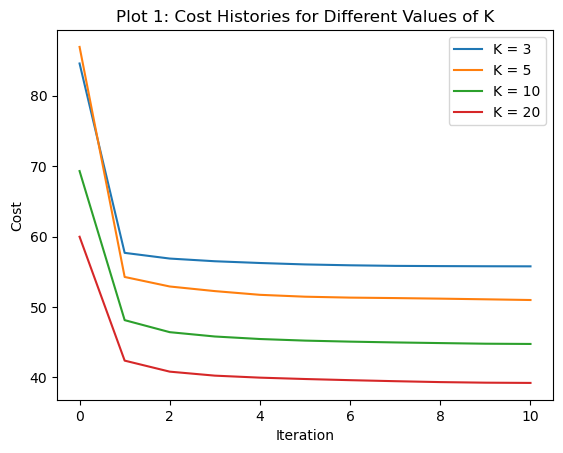

In [4]:
# test the clusters function with several values of K
centroids, cost_history3 = clusters(x, 3, 10)
centroids, cost_history5 = clusters(x, 5, 10)
centroids, cost_history10 = clusters(x, 10, 10)
centroids, cost_history20 = clusters(x, 20, 10)

classifications = classify(x, centroids)

# plot cost histories
plt.plot(cost_history3)
plt.plot(cost_history5)
plt.plot(cost_history10)
plt.plot(cost_history20)
plt.title("Plot 1: Cost Histories for Different Values of K")
plt.legend(["K = 3", "K = 5", "K = 10", "K = 20"])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

As one would expect, the cost decreases with each iteration as the classification becomes better. The cost reaches very near to its minimum after 4 iterations, for the 4 values of K here. It appears to take a little bit longer to reach a minimum for larger values of K, since the classification becomes more complex.

Larger values of K result in lower costs. This is because more centroids means that any data point is likely to be closer to one of them.

Next, a scree plot will be used to determine the optimal value of K. A scree plot plots the cost against K. This should be a monotonically decreasing plot, because the cost is lower for larger values of K. But a good choice for K will be one where the plot decreases more rapidly before this value for K, where each added cluster greatly decreases the cost. 

In [5]:
# plot for K from 1 to 20
# make 3 scree plots, to account for randomness
K = np.arange(1, 21)
scree_data1 = np.zeros(K.shape)
scree_data2 = np.zeros(K.shape)
scree_data3 = np.zeros(K.shape)

for i in range(0, K.shape[0]):
    # take 5 iterations, which is enough considering Plot 1
    centroids, costs = clusters(x, K[i], 5)
    scree_data1[i] = costs[-1]
    centroids, costs = clusters(x, K[i], 5)
    scree_data2[i] = costs[-1]
    centroids, costs = clusters(x, K[i], 5)
    scree_data3[i] = costs[-1]

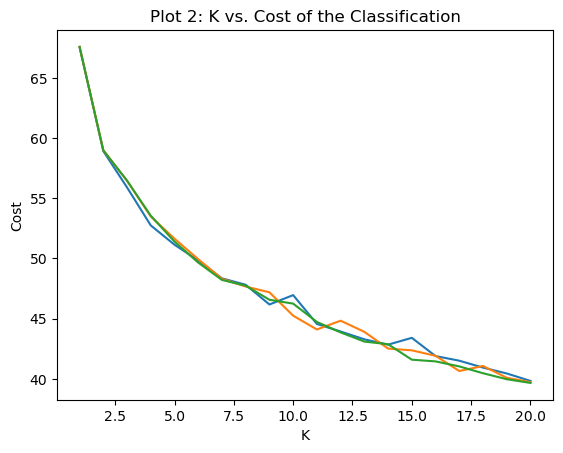

In [6]:
# plot scree data
plt.plot(K, scree_data1)
plt.plot(K, scree_data2)
plt.plot(K, scree_data3)
plt.title("Plot 2: K vs. Cost of the Classification")
plt.xlabel("K")
plt.ylabel("Cost")
plt.show()

When plotting K against the cost, the plot can appear quite rough since there is some randomness in the classification. Therefore 3 separate runs are plotted, each one using a different initial guess for the positions of the centroids.

An optimal value of K would have the plot decreasing rapidly before and more slowly afterwards, indicating that increasing K before the optimal value greatly increases the quality of the classification, while after does not do much good.

In this case, no such optimal point is obvious, but in what follows, I will take K = 10, meaning the music will be sorted into 10 genres.

To get a good classification of the data, I will take 10 iterations. Based on Plot 1, this will be enough.

In [7]:
# classify the music into 10 genres, using 10 iterations
centroids, cost_history = clusters(x, 10, 10)
classification = classify(x, centroids)

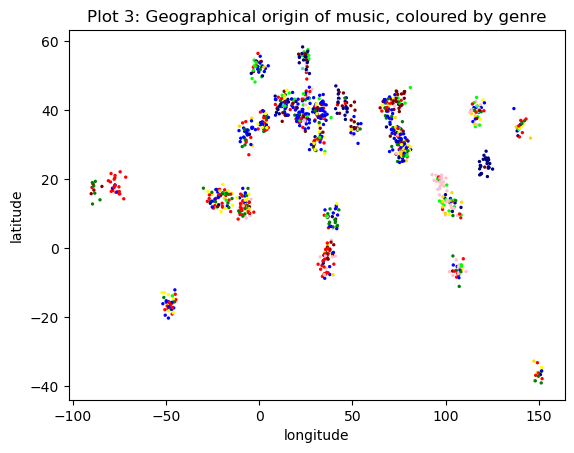

In [8]:
# plot the music based on geographical origin, and colour by classification
colormap = ['red', 'maroon', 'gold', 'yellow', 'lime', 'green', 'turquoise', 'blue', 'navy', 'pink']
plt.scatter(y_offset[:, 1], y_offset[:, 0], s=2, c = np.take(colormap, classification))
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("Plot 3: Geographical origin of music, coloured by genre")
plt.show()

The genres imposed by K-means clustering show some clear patterns when the data is plotted by geographical origin. There are some areas which are almost exclusively of one genre, for example, at 24 N, 121 E (which is Taiwan). A likely explanation is that the data contains only one artist from Taiwan. There are also more diverse areas, for example 16 S, 48 W (Brazil). The data could contain more than one Brazilian artist, or perhaps one Brazilian artist with a wider range of output.

In general, if we choose any single genre there will be pieces in that genre from all over the world, but it will appear to be more concentrated in some areas. For example, blue (in this run) appears nearly everywhere, but it seems particularly dominant in the center north (Europe). This is expected, since a genre is most likely popular in a particular area but it will influence musicians around the world.

Now I will use neural networks made with tensorflow to build a model predicting the origin of music. First, the data will be labelled based on whether it is below (0) or above (1) the latitude line 20 N, which approximately splits the data in half. 

In [9]:
from tensorflow import keras

In [10]:
# reshape x back to original shape
x.shape = (x.shape[0], x.shape[2])

In [11]:
# create labels
y_20 = y[:, 0] > 20

# check how much of the data is above 20 N
print(np.count_nonzero(y_20), 'out of', np.size(y_20), 'music samples are above 20 N')

# convert y to one-hot encoding
y_20 = keras.utils.to_categorical(y_20)

# choose training and validation sets, training set has size 800, validation set has size 259
x_train = x[:800, :]
y_train = y_20[:800]
x_val = x[800:, :]
y_val = y_20[800:]

679 out of 1059 music samples are above 20 N


First, I will attempt classification with a single-layer model.

In [12]:
# create a model with a single dense layer
model_simple = keras.models.Sequential([
    keras.layers.Dense(2, batch_input_shape = (None, 68), activation='sigmoid')
])

model_simple.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [13]:
history = model_simple.fit(x_train, y_train,
                  validation_data=(x_val,y_val),
                  batch_size=64, 
                  epochs=100,
                  verbose=0)

In [14]:
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 138       
                                                                 
Total params: 138
Trainable params: 138
Non-trainable params: 0
_________________________________________________________________


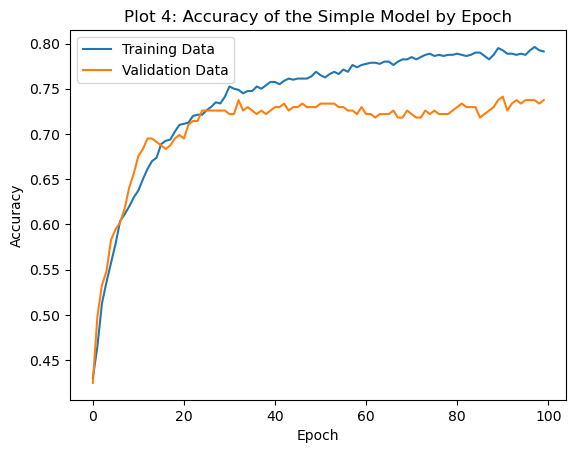

Max training accuracy: 0.7962499856948853
Max validation accuracy: 0.7413127422332764


In [15]:
# plot training accuracy and validation accuracy
plt.title("Plot 4: Accuracy of the Simple Model by Epoch")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Training Data', 'Validation Data'])
plt.show()

# print maximum of the plots
print("Max training accuracy:", np.max(history.history['accuracy']))
print("Max validation accuracy:", np.max(history.history['val_accuracy']))

Because the model is attempting to fit to the training data, it acheives a much higher accuracy on the training data than the validation data. However, the validation data serves as a test of how well the model will perform given an arbitrary piece of music, so the validation accuracy is more useful.

The highest accuracy on the validation data is around 74%. For comparison, guessing all music comes from above 20 N would result in an accuracy of 679 / 1059 = 64%. To attempt to improve the model, I will add a hidden layer. 

In [16]:
# create a model with a hidden layer
model_hidden = keras.models.Sequential([
    keras.layers.Dense(32, batch_input_shape = (None, 68), activation='relu'),
    keras.layers.Dense(2, batch_input_shape = (None, 32), activation='softmax')
])

model_hidden.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [17]:
history = model_hidden.fit(x_train, y_train,
                  validation_data=(x_val,y_val),
                  batch_size=64, 
                  epochs=100,
                  verbose=0)

In [18]:
model_hidden.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                2208      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2,274
Trainable params: 2,274
Non-trainable params: 0
_________________________________________________________________


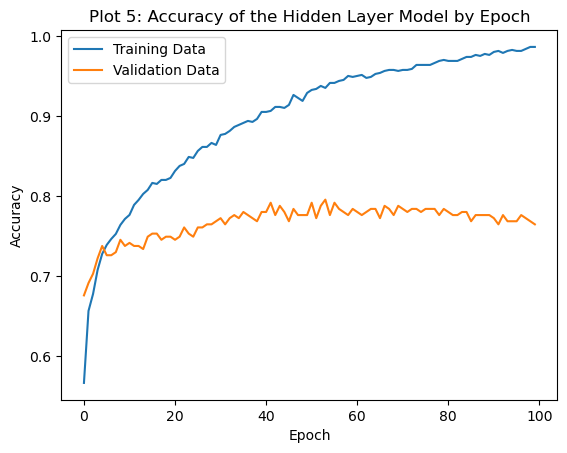

Max training accuracy: 0.9862499833106995
Max validation accuracy: 0.7953668236732483


In [19]:
# plot training accuracy and validation accuracy
plt.title("Plot 5: Accuracy of the Hidden Layer Model by Epoch")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Training Data', 'Validation Data'])
plt.show()

# print the maximum of the plots
print("Max training accuracy:", np.max(history.history['accuracy']))
print("Max validation accuracy:", np.max(history.history['val_accuracy']))

With this model, the validation accuracy reached a maximum of 80%, which is somewhat better than the simple model. This comes at the cost of a higher complexity (2,274 parameters compared to 138 on the simple model). Because the gain in accuracy is so small, the simple model could be preferable.

The accuracy of 80% means that the hidden-layer model can guess better than random, so a weak correlation exists. This is expected, since some musical features are more dominant in some areas, but they will have a global influence so the music cannot be classified perfectly.

In the hidden-layer model, the validation data begins to decrease slightly past epoch 40, while the training accuracy increases all the way up to an unrealistic 99%. This is because the model is overfitting. It is fitting to noise in the training set, so it finds trends which happen to exist in the training set but do not reflect real trends present in other music. This decreases the accuracy of the model on the validation data. Therefore, it is best to stop training the model around epoch 40.